In [1]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch

In [2]:
data_dir = Path("D:/DATA/goodreads/genre")

In [3]:
def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [4]:
interactions_path = data_dir / "goodreads_interactions_poetry.json.gz"

interactions_all = (load_data(interactions_path, head=None))
print(f"Number of all interactions = {len(interactions_all):,}")
interactions_pos = [i for i in interactions_all if i["rating"]>3]
print(f"Number of positive interactions = {len(interactions_pos):,} (with rating > 3)")
assert interactions_pos

Number of all interactions = 2,734,350
Number of positive interactions = 906,536 (with rating > 3)


100%|██████████| 906536/906536 [00:52<00:00, 17327.04it/s]


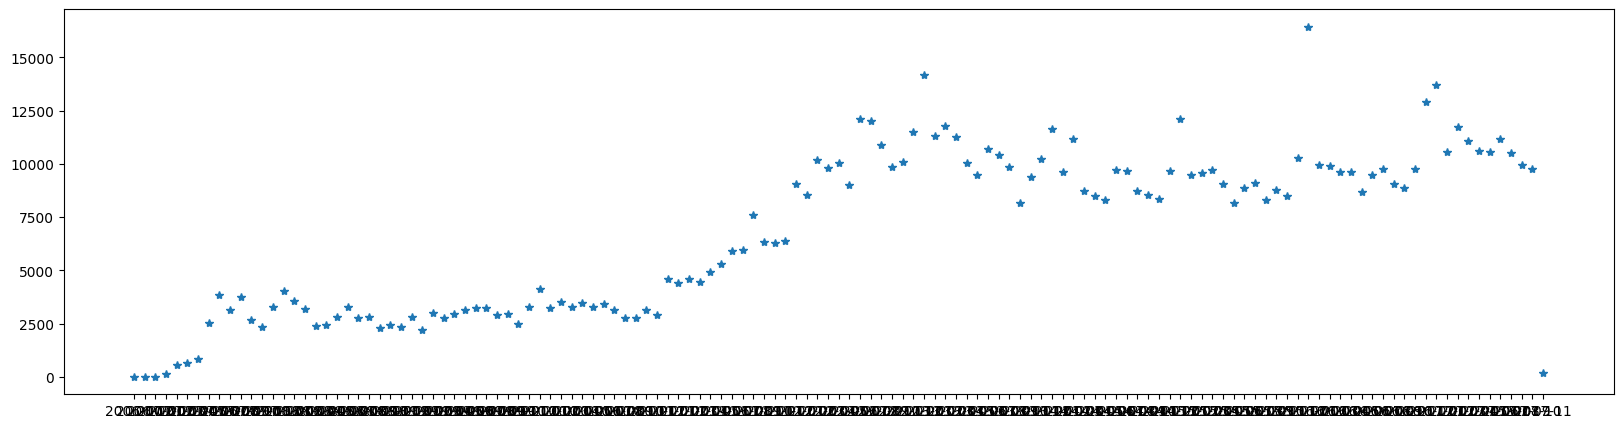

In [6]:
users, items, dates = [], [], []
for interaction in tqdm(interactions_pos):
    users.append(interaction["user_id"])
    items.append(interaction["book_id"])
    t = interaction["date_updated"]
    t = dt.datetime.strptime(t, "%a %b %d %H:%M:%S %z %Y")
    dates.append(t.date())

# see monthly interaction number
data_df = pd.DataFrame({"user":users, "item":items, "date":dates})
data_df["date"] = pd.to_datetime(data_df["date"])
data_df["year_month"] = data_df["date"].dt.strftime('%Y-%m')

ineractions_grouped = data_df.value_counts("year_month").sort_index()
plt.figure(figsize=(20,5))
plt.plot(ineractions_grouped, "*")
plt.show()

,year_month,intercations_count
0,2006-10,2
1,2006-12,3
2,2007-01,4
3,2007-02,127
4,2007-03,561
...,...,...
128,2017-07,11143
129,2017-08,10521
130,2017-09,9952
131,2017-10,9754


In [33]:
ints_grouped_df = ineractions_grouped.to_frame("count").reset_index()
ints_grouped_df["cumsum"] = ints_grouped_df["count"].cumsum() / ints_grouped_df["count"].sum()
ints_grouped_df[(ints_grouped_df["cumsum"] > 0.89) & (ints_grouped_df["cumsum"] < 0.93)]

,year_month,count,cumsum
122,2017-01,13714,0.893966
123,2017-02,10571,0.905626
124,2017-03,11743,0.918580


## Train and test split & Filtering & Mapping

In [42]:
print("min date =", ints_grouped_df["year_month"].min())
print("max date =", ints_grouped_df["year_month"].max())
cutoff_date = dt.datetime.strptime("2017-02-01", "%Y-%m-%d").date()
print("cutoff date = ", cutoff_date)

train_df = data_df[data_df["date"].dt.date < cutoff_date]
test_df = data_df[data_df["date"].dt.date >= cutoff_date]
print(f"Train count = {train_df.shape[0]}")
print(f"Test count = {test_df.shape[0]}")

min date = 2006-10
max date = 2017-11
cutoff date =  2017-02-01
Train count = 810412
Test count = 96124


In [54]:
print(f"Number of observations before filters = {train_df.shape[0]}")
# filter out users and items with low amount of interactions
n_int_user = 5
n_int_item = 10

users_int_count = train_df.value_counts("user").to_frame(name="user_int_count").reset_index()
users_int_count = users_int_count[users_int_count.user_int_count >= n_int_user]
train_df_filtered = train_df.merge(users_int_count, on="user", how="inner")
print(f"Number of observations after filtering users = {train_df_filtered.shape[0]}")

items_int_count = train_df_filtered.value_counts("item").to_frame(name="item_int_count").reset_index()
items_int_count = items_int_count[items_int_count.item_int_count >= n_int_item]
train_df_filtered = train_df_filtered.merge(items_int_count, on="item", how="inner")

print(f"Number of observations after filtering users and items = {train_df_filtered.shape[0]}")


Number of observations before filters = 810412
Number of observations after filtering users = 518147
Number of observations after filtering users and items = 446244


In [55]:
# map users & items
print(f"Number of users before filtering = {train_df.user.nunique()}")
print(f"Number of items before filtering = {train_df.item.nunique()}")

users_unique = np.unique(train_df_filtered.user.values)
items_unique = np.unique(train_df_filtered.item.values)
u_to_id= {u:idx for idx,u in enumerate(users_unique)}
i_to_id = {i:idx for idx,i in enumerate(items_unique)}

train_df_filtered["user_mapped"] = train_df_filtered["user"].apply(lambda x: u_to_id[x])
train_df_filtered["item_mapped"] = train_df_filtered["item"].apply(lambda x: i_to_id[x])

print(f"Number of users after filtering = {train_df_filtered.user.nunique()}")
print(f"Number of items after filtering = {train_df_filtered.item.nunique()}")

Number of users before filtering = 210611
Number of items before filtering = 31673
Number of users after filtering = 39942
Number of items after filtering = 6917


In [65]:
# filter test set and map users & items
print(f"Number of observations in test set before filtering = {test_df.shape[0]}")
print(f"Number of user in test set before filtering = {test_df.user.nunique()}")
print(f"Number of items in test set before filtering = {test_df.item.nunique()}")

print("---"*20)
test_df_filtered = test_df.merge(pd.DataFrame({"user":users_unique}), on="user", how="inner")
test_df_filtered = test_df_filtered.merge(pd.DataFrame({"item":items_unique}), on="item", how="inner")
test_df_filtered["user_mapped"] = test_df_filtered["user"].apply(lambda x: u_to_id[x])
test_df_filtered["item_mapped"] = test_df_filtered["item"].apply(lambda x: i_to_id[x])

print(f"Number of observations in test set after filtering = {test_df_filtered.shape[0]}")
print(f"Number of user in test set after filtering = {test_df_filtered.user.nunique()}")
print(f"Number of items in test set after filtering = {test_df_filtered.item.nunique()}")


Number of observations in test set before filtering = 96124
Number of user in test set before filtering = 44224
Number of items in test set before filtering = 15568
------------------------------------------------------------
Number of observations in test set after filtering = 18097
Number of user in test set after filtering = 7040
Number of items in test set after filtering = 4257


## Torch geometric dataset

In [67]:
train = HeteroData()

train["user"].node_id = torch.tensor(list(u_to_id.values()))
train["item"].node_id = torch.tensor(list(i_to_id.values()))
train['user', "likes", 'item'].edge_index = torch.stack([torch.tensor(train_df.user_mapped.values), 
                                                         torch.tensor(train_df.item_mapped.values)], dim=0)
train['user', 'likes', 'item'].edge_label = torch.ones((train_df.shape[0]),)

train = T.ToUndirected()(train)

In [ ]:
train.edge_types

[('user', 'likes', 'item'), ('item', 'rev_likes', 'user')]

In [74]:
train

HeteroData(
  user={ node_id=[39942] },
  item={ node_id=[6917] },
  (user, likes, item)={
    edge_index=[2, 810412],
    edge_label=[810412],
  },
  (item, rev_likes, user)={
    edge_index=[2, 810412],
    edge_label=[810412],
  },
  (user, rev_likes, item)={}
)

In [ ]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    train,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[2] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=1,
    input_nodes=('', data['paper'].train_mask),
)

next(iter(train_loader))

## Model